In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Implement a basic driving agent

The agent randomly moves on the grid. It takes lots of penalties. It eventually makes it to the target location but a lot of time after deadline is passed (generally 20 to 40 turns after deadline is passed).

## Identify and update states

Initially I reported the state as follows:
- self.state = (inputs[0],inputs[1],inputs[2],inputs[3],self.next_waypoint,deadline)
- inputs[0] : provides information about the color of the traffic light at the current cross road
- inputs[1],inputs[2],inputs[3] : let the agent know about incoming traffic. With only three other cars on the road. 
Those inputs are most of the time set to None. But with enough training, the car will be able to behave accordingly.
- self.next_waypoint : provides the planner direction to reach destination as quickly as possible (but does not take into account other cars and traffic lights)
- deadline : provides the time left to reach destination

Ideally, the car would collect as many rewards as possible while reaching destination before deadline. Nonetheless, it multiplies the number of states to such an extend that I decided to remove it from the state definition so that the state space can be learned in a decent amount of time.

The state space is 2 (lights) * 4 ^ 3 (incoming traffic)  * 4 (route planner) = 512

We don’t expect to explore 100 % of it since there are some combinaisons are very unlikely to happen. With only 3 other cars on the grid meeting several cars at at once will probably not happen within 100 trials.


## Implement Q-learning

Implementing Q-learning without randomly choosing an action from time to time does not perform better than the random policy. The agent always chooses the action it has previously selected in the same state.

Adding some random exploration in the decision related to each step eventually leads to an agent following the planner while respecting traffic rules.

I chose epsilon = 0.5 multiplying this number by 0.99 each time the agent makes a random move, so that the randomness of its actions decays over time and it uses the leanrned policy.

With this value, we initially have random exploration of the different state and after the turn 1000 a q value that is quite stable (between 4 and 5, see graph below)

In [2]:
def q_values_e(epsilon):
    file_object = open('q_values_e_{0}'.format(epsilon),'r')
    q = pickle.load(file_object)
    y = []
    x = []
    state = ((('light', 'green'),('oncoming', None),('right', None),('left', None),'forward'),'forward')
    for i in range(len(q)):
        if q[i][0].keys() == [state]: 
            y.append(q[i][0][state])
            x.append(q[i][1])
    return x,y

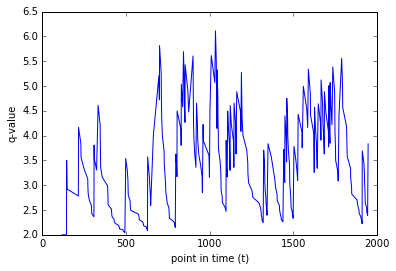

In [3]:
plt.plot(q_values_e(0.1)[0],q_values_e(0.1)[1])
plt.xlabel('point in time (t)')
plt.ylabel('q-value');

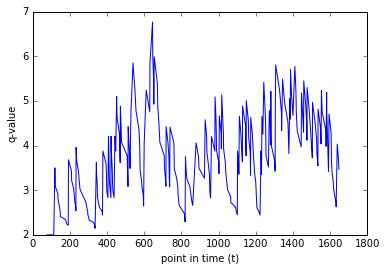

In [4]:
plt.plot(q_values_e(0.5)[0],q_values_e(0.5)[1])
plt.xlabel('point in time (t)')
plt.ylabel('q-value');

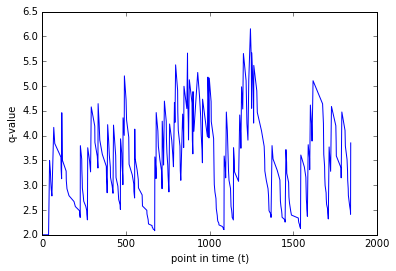

In [5]:
plt.plot(q_values_e(0.8)[0],q_values_e(0.8)[1])
plt.xlabel('point in time (t)')
plt.ylabel('q-value');

To chose the value of alpha, we tested and made graphs (see below) of several values of alpha for a particular state.

When alpha is "big" (0.5), the associated q-values are not stable over time making it harder to converge to a stable policy. Hence we favor a smaller value : 0.075 or 0.15

In [6]:
def q_values(alpha):
    file_object = open('q_values_{0}'.format(alpha),'r')
    q = pickle.load(file_object)
    y = []
    x = []
    state = ((('light', 'green'),('oncoming', None),('right', None),('left', None),'forward'),'forward')
    for i in range(len(q)):
        if q[i][0].keys() == [state]: 
            y.append(q[i][0][state])
            x.append(q[i][1])
    return x,y

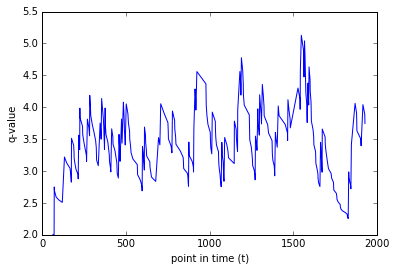

In [7]:
plt.plot(q_values(0.075)[0],q_values(0.075)[1])
plt.xlabel('point in time (t)')
plt.ylabel('q-value');

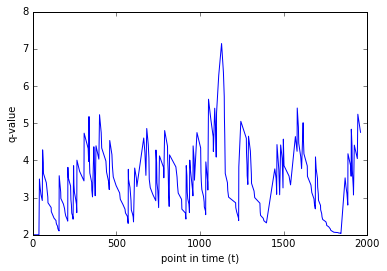

In [8]:
plt.plot(q_values(0.15)[0],q_values(0.15)[1])
plt.xlabel('point in time (t)')
plt.ylabel('q-value');

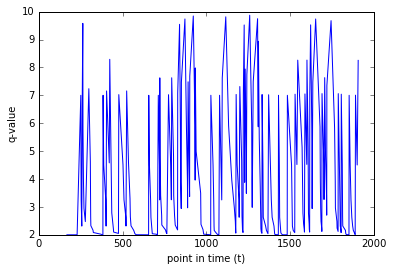

In [9]:
plt.plot(q_values(0.5)[0],q_values(0.5)[1])
plt.xlabel('point in time (t)')
plt.ylabel('q-value');

In [10]:
print 'for alpha = 0.075 standard deviation of the q values is {0}'.format(np.std(q_values(0.075)[1]))
print 'for alpha = 0.015 standard deviation of the q values is {0}'.format(np.std(q_values(0.15)[1]))
print 'for alpha = 0.5 standard deviation of the q values is {0}'.format(np.std(q_values(0.5)[1]))


for alpha = 0.075 standard deviation of the q values is 0.548066364466
for alpha = 0.015 standard deviation of the q values is 0.876237519645
for alpha = 0.5 standard deviation of the q values is 2.17987289959


## Final Thoughts

When combining a suitable epsilon and alpha we manage to get an agent that is doing consistently better reaching the destination 75 times out of 100.

The optimal policy is to combine the route planner indications while paying attention to traffic lights and traffic.